In [1]:

import pandas as pd
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import os
import pytesseract
import matplotlib.pyplot as plt
import jiwer
%matplotlib inline

In [2]:
# Set the path for Tesseract-OCR executable

dataset_path = '../../../IAM_Words/words'  # Update the path as necessary
data = []
words = open("../ascii/words.txt", "r").readlines()
inexistent_or_corrupted = 0

for line in tqdm(words):
    if line.startswith("#"):
        continue
    parts = line.strip().split()
    fixed_part = parts[:8]
    transcription_part = ' '.join(parts[8:])

    line_split = line.split(" ")
    folder_parts = line_split[0].split('-')
    folder1 = folder_parts[0]
    folder2 = folder_parts[0] + '-' + folder_parts[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')
    rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

    if os.path.exists(rel_path) and os.path.getsize(rel_path) > 0:
        data.append(fixed_part + [transcription_part, rel_path])
    else:
        inexistent_or_corrupted += 1

print('Inexistent or corrupted images:', inexistent_or_corrupted)
df = pd.DataFrame(data, columns=['line_id', 'result', 'graylevel', 'x', 'y', 'w', 'h', 'annotation', 'transcription', 'image_path'])
display(df.head())


100%|██████████| 115338/115338 [00:03<00:00, 36024.79it/s]


Inexistent or corrupted images: 2


,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../../IAM_Words/words/a01/a01-000u/a01-000u...
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../../IAM_Words/words/a01/a01-000u/a01-000u...
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../../IAM_Words/words/a01/a01-000u/a01-000u...
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../../IAM_Words/words/a01/a01-000u/a01-000u...
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../../IAM_Words/words/a01/a01-000u/a01-000u...


In [3]:

# Check transcription distribution
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcription with fewer than 2 samples
min_samples = 2
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()
df_filtered.reset_index(drop=True, inplace=True)

# Check transcription distribution after filtering
print("Transcription distribution after filtering:")
print(df_filtered['transcription'].value_counts())



Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Transcription distribution after filtering:
transcription
the          5826
,            5570
.            4984
of           3192
to           2651
             ... 
specified       2
palm            2
smoothing       2
gate            2
doorman         2
Name: count, Length: 6360, dtype: int64


In [4]:
# Initialize the 'extracted_text' column with an empty string or pd.NA
df_filtered['extracted_text'] = ''
df_filtered = df_filtered.head(1000).copy()
# Define the filters as functions
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image):
    return cv2.medianBlur(image, 5)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def dilate(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.erode(image, kernel, iterations=1)

def opening(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def canny(image):
    return cv2.Canny(image, 100, 200)

missing_translation = 0

# Extract text using pytesseract
for index, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    try:
        image_path = row['image_path']

        # Read the image using OpenCV
        image = cv2.imread(image_path)

        # Convert to grayscale
        gray = get_grayscale(image)

        # Apply noise removal
        noise_removed = remove_noise(gray)

        # Apply thresholding
        thresh = thresholding(noise_removed)

        # Apply dilation
        dilation = dilate(thresh)

        # Apply erosion
        erosion = erode(thresh)

        # Apply opening
        open_image = opening(thresh)

        # Apply Canny edge detection
        canny_edges = canny(thresh)

        # Choose one of the processed images for text extraction
        # Here, we're using the final processed image from the opening filter
        final_image = noise_removed  # Change this to any processed image you want to use

        # Extract text using pytesseract
        # Page Segmentation Mode (PSM) Treat the image as a single text line
        # OCR Engine Mode (OEM) default OCR Engine Mode
        extracted_text = pytesseract.image_to_string(Image.fromarray(final_image), config='--oem 3 --psm 7 -l eng')
        df_filtered.at[index, 'extracted_text'] = extracted_text.strip()

        # Log the extracted text
        # print(f"Extracted Text from {image_path}: {extracted_text.strip()}")

        # Check if the extracted text is empty and log a warning
        if extracted_text == "":
            missing_translation += 1
            #print(f"Warning: No text extracted from {image_path}")

    except Exception as e:
        print(f"Error processing image at index {index}, {image_path}: {e}")
        # Optionally set the extracted text to an empty string or leave as is
        
print(f'{(missing_translation / len(df_filtered)) * 100}%({missing_translation}/{len(df_filtered)}) extracted texts are missing')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s]

3.8%(38/1000) extracted texts are missing


In [5]:
display(df_filtered.head())
display(len(df_filtered))
display(df_filtered.describe())

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,extracted_text
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../../IAM_Words/words/a01/a01-000u/a01-000u...,A
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../../IAM_Words/words/a01/a01-000u/a01-000u...,MOVE
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../../IAM_Words/words/a01/a01-000u/a01-000u...,40
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../../IAM_Words/words/a01/a01-000u/a01-000u...,aoe
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../../IAM_Words/words/a01/a01-000u/a01-000u...,Mur


1000

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,extracted_text
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,2,34,765,695,389,152,59,208,1000,822
top,a01-000u-00-00,ok,182,325,2015,9,66,NN,the,../../../IAM_Words/words/a01/a01-000u/a01-000u...,
freq,1,860,152,5,6,14,24,121,40,1,38


In [6]:
# Define the transformations using jiwer.Compose
transforms = jiwer.Compose(
    [
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ]
)

# Initialize counters
no_translation = 0
multiple_translations = 0

# Function to calculate and print WER
def calculate_wer(reference, extracted_text):
    global no_translation, multiple_translations  # Declare the variables as global

    # Check if reference or extracted_text is empty
    if not reference or not extracted_text:
        no_translation += 1
        return None

    # Convert reference and extracted_text to lists of words
    reference_list = reference.split() if isinstance(reference, str) else []
    extracted_text_list = extracted_text.split() if isinstance(extracted_text, str) else []

    # Ensure the lists are not empty before calculating WER
    if not reference_list or not extracted_text_list:
        no_translation += 1
        return None

    # Calculate the Word Error Rate (WER)
    try:
        wer_value = jiwer.wer(
            reference_list,
            extracted_text_list,
            truth_transform=transforms,
            hypothesis_transform=transforms,
        )
        return wer_value
    except ValueError as e:
        multiple_translations += 1
        return None

# Apply the WER calculation to the DataFrame
df_filtered['WER'] = df_filtered.apply(
    lambda row: calculate_wer(row['transcription'], row['extracted_text']), axis=1
)

# Handle NaN values
df_filtered['WER'].fillna(1, inplace=True)

# Print summary of missing translations and multiple translations
print(f'{(no_translation / len(df_filtered)) * 100}% ({no_translation}/{len(df_filtered)}) extracted texts are missing')
print(f'{(multiple_translations / len(df_filtered)) * 100}% ({multiple_translations}/{len(df_filtered)}) extracted texts are not valid for WER calculation')

3.8% (38/1000) extracted texts are missing
38.4% (384/1000) extracted texts are not valid for WER calculation


/tmp/ipykernel_61575/1359641294.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['WER'].fillna(1, inplace=True)


In [7]:

# Display results
display(df_filtered[['transcription', 'extracted_text', 'WER']].head())

,transcription,extracted_text,WER
0,A,A,0.0
1,MOVE,MOVE,0.0
2,to,40,1.0
3,stop,aoe,1.0
4,Mr.,Mur,1.0


In [8]:
# Evaluate OCR performance
df_filtered['correct'] = df_filtered['transcription'] == df_filtered['extracted_text']
accuracy = df_filtered['correct'].mean()
print(f"OCR Accuracy: {accuracy:.2f}")

OCR Accuracy: 0.03


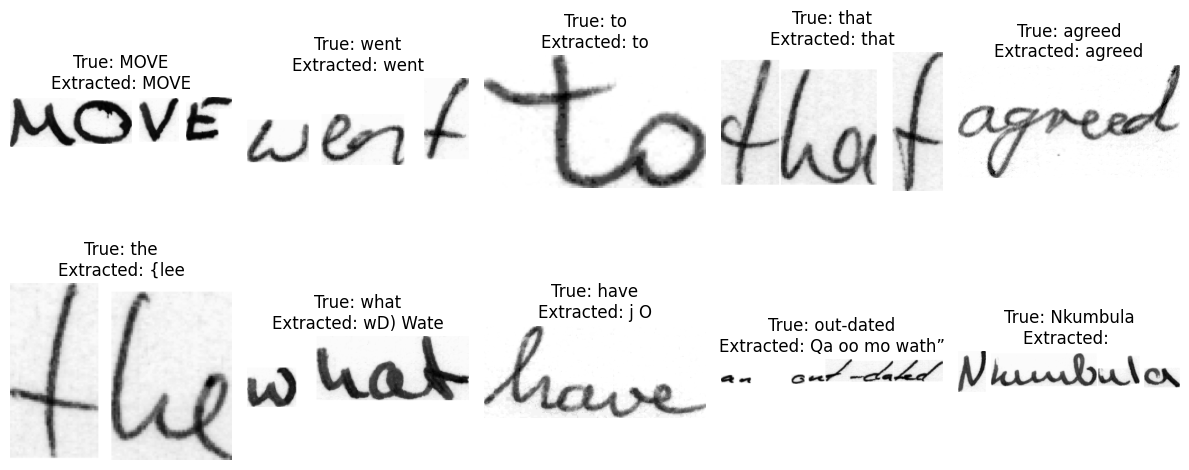

In [9]:
# Display some examples of correct and incorrect predictions
num_samples = 5

# Sample correct predictions
correct_samples = df_filtered[df_filtered['correct']]
if len(correct_samples) < num_samples:
    correct_samples = correct_samples.sample(len(correct_samples))  # Sample all if fewer than num_samples
else:
    correct_samples = correct_samples.sample(num_samples)

# Sample incorrect predictions
incorrect_samples = df_filtered[~df_filtered['correct']]
if len(incorrect_samples) < num_samples:
    incorrect_samples = incorrect_samples.sample(len(incorrect_samples))  # Sample all if fewer than num_samples
else:
    incorrect_samples = incorrect_samples.sample(num_samples)

plt.figure(figsize=(12, 6))

# Display correct predictions
for i, row in enumerate(correct_samples.iterrows()):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(Image.open(row[1]['image_path']), cmap='gray')
    plt.title(f'True: {row[1]["transcription"]}\nExtracted: {row[1]["extracted_text"]}')
    plt.axis('off')

# Display incorrect predictions
for i, row in enumerate(incorrect_samples.iterrows()):
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(Image.open(row[1]['image_path']), cmap='gray')
    plt.title(f'True: {row[1]["transcription"]}\nExtracted: {row[1]["extracted_text"]}')
    plt.axis('off')

plt.tight_layout()
plt.show()